# Feature Selection

This notebook implements various feature selection techniques:
1. Feature Importance using Random Forest
2. Recursive Feature Elimination (RFE)
3. Chi-Square Test for feature significance
4. Combine results to select optimal features
5. Save selected features dataset


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, chi2, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Load preprocessed data
X_train_scaled = pd.read_csv('../data/X_train_scaled.csv')
X_test_scaled = pd.read_csv('../data/X_test_scaled.csv')
y_train = pd.read_csv('../data/y_train.csv').squeeze()
y_test = pd.read_csv('../data/y_test.csv').squeeze()

# Also load original (non-scaled) data for chi-square test
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Feature names: {list(X_train_scaled.columns)}")
print(f"Target distribution: {y_train.value_counts().sort_index().values}")


Training data shape: (242, 13)
Feature names: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Target distribution: [131 111]


## 1. Feature Importance using Random Forest


Random Forest Feature Importance:
     feature  importance
7    thalach    0.135404
2         cp    0.127163
12      thal    0.122940
11        ca    0.100811
0        age    0.091327
9    oldpeak    0.089358
4       chol    0.088681
3   trestbps    0.080716
8      exang    0.050730
10     slope    0.046626
1        sex    0.035947
6    restecg    0.018389
5        fbs    0.011908


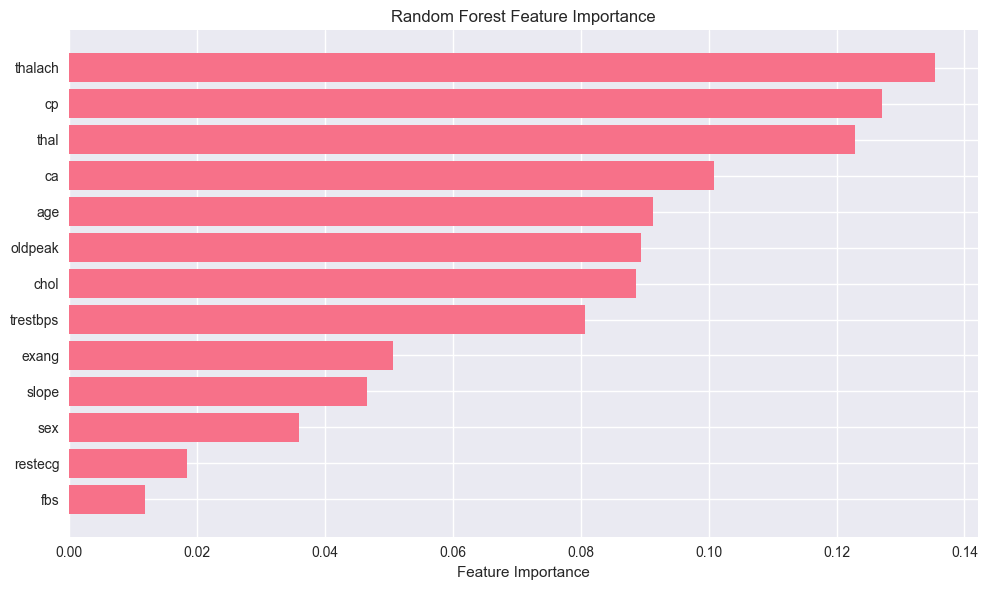


Features selected by Random Forest (importance >= 0.05): 9
['thalach', 'cp', 'thal', 'ca', 'age', 'oldpeak', 'chol', 'trestbps', 'exang']


In [3]:
# Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Random Forest Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Select top features based on importance threshold
importance_threshold = 0.05
rf_selected_features = feature_importance[feature_importance['importance'] >= importance_threshold]['feature'].tolist()
print(f"\nFeatures selected by Random Forest (importance >= {importance_threshold}): {len(rf_selected_features)}")
print(rf_selected_features)


## 2. Recursive Feature Elimination (RFE)



RFE with 5 features:
Selected features: ['sex', 'cp', 'slope', 'ca', 'thal']

RFE with 7 features:
Selected features: ['sex', 'cp', 'thalach', 'exang', 'slope', 'ca', 'thal']

RFE with 10 features:
Selected features: ['sex', 'cp', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'slope', 'ca', 'thal']

Optimal RFE selection (7 features):
['sex', 'cp', 'thalach', 'exang', 'slope', 'ca', 'thal']


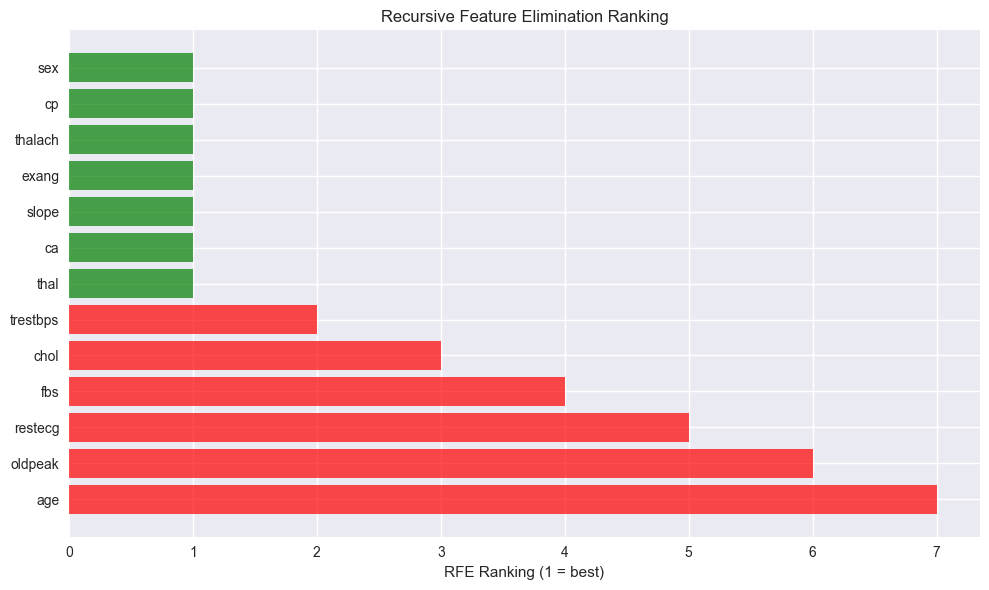

In [4]:
# Recursive Feature Elimination with Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000)

# Try different numbers of features
n_features_to_select = [5, 7, 10]
rfe_results = {}

for n_features in n_features_to_select:
    rfe = RFE(estimator=lr, n_features_to_select=n_features)
    rfe.fit(X_train_scaled, y_train)
    
    selected_features = X_train_scaled.columns[rfe.support_].tolist()
    rfe_results[n_features] = {
        'features': selected_features,
        'ranking': rfe.ranking_
    }
    
    print(f"\nRFE with {n_features} features:")
    print(f"Selected features: {selected_features}")

# Use 7 features as optimal (good balance)
optimal_n_features = 7
rfe_optimal = RFE(estimator=lr, n_features_to_select=optimal_n_features)
rfe_optimal.fit(X_train_scaled, y_train)
rfe_selected_features = X_train_scaled.columns[rfe_optimal.support_].tolist()

print(f"\nOptimal RFE selection ({optimal_n_features} features):")
print(rfe_selected_features)

# Visualize RFE ranking
rfe_ranking_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'ranking': rfe_optimal.ranking_,
    'selected': rfe_optimal.support_
}).sort_values('ranking')

plt.figure(figsize=(10, 6))
colors = ['green' if selected else 'red' for selected in rfe_ranking_df['selected']]
plt.barh(range(len(rfe_ranking_df)), rfe_ranking_df['ranking'], color=colors, alpha=0.7)
plt.yticks(range(len(rfe_ranking_df)), rfe_ranking_df['feature'])
plt.xlabel('RFE Ranking (1 = best)')
plt.title('Recursive Feature Elimination Ranking')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 3. Chi-Square Test for Feature Significance


In [5]:
# Prepare data for chi-square test (need non-negative values)
# Scale to [0, 1] range using MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

# Convert to DataFrame
X_train_minmax_df = pd.DataFrame(X_train_minmax, columns=X_train.columns, index=X_train.index)
X_test_minmax_df = pd.DataFrame(X_test_minmax, columns=X_test.columns, index=X_test.index)

# Apply Chi-Square test
chi2_selector = SelectKBest(chi2, k=8)  # Select top 8 features
X_train_chi2 = chi2_selector.fit_transform(X_train_minmax, y_train)

# Get chi-square scores
chi2_scores = chi2_selector.scores_
chi2_pvalues = chi2_selector.pvalues_

# Create DataFrame with results
chi2_results = pd.DataFrame({
    'feature': X_train.columns,
    'chi2_score': chi2_scores,
    'p_value': chi2_pvalues,
    'selected': chi2_selector.get_support()
}).sort_values('chi2_score', ascending=False)

print("Chi-Square Test Results:")
print(chi2_results)

# Get selected features
chi2_selected_features = X_train.columns[chi2_selector.get_support()].tolist()
print(f"\nFeatures selected by Chi-Square test: {len(chi2_selected_features)}")
print(chi2_selected_features)


Chi-Square Test Results:
     feature  chi2_score       p_value  selected
12      thal   39.673186  3.002192e-10      True
8      exang   28.791571  8.060112e-08      True
11        ca   20.670175  5.455926e-06      True
10     slope    8.078705  4.478844e-03      True
9    oldpeak    7.544053  6.020844e-03      True
1        sex    7.320776  6.816198e-03      True
2         cp    5.699117  1.697345e-02      True
6    restecg    3.162825  7.533273e-02      True
7    thalach    2.010533  1.562104e-01     False
0        age    0.699249  4.030361e-01     False
5        fbs    0.435893  5.091116e-01     False
3   trestbps    0.353795  5.519727e-01     False
4       chol    0.073936  7.856899e-01     False

Features selected by Chi-Square test: 8
['sex', 'cp', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


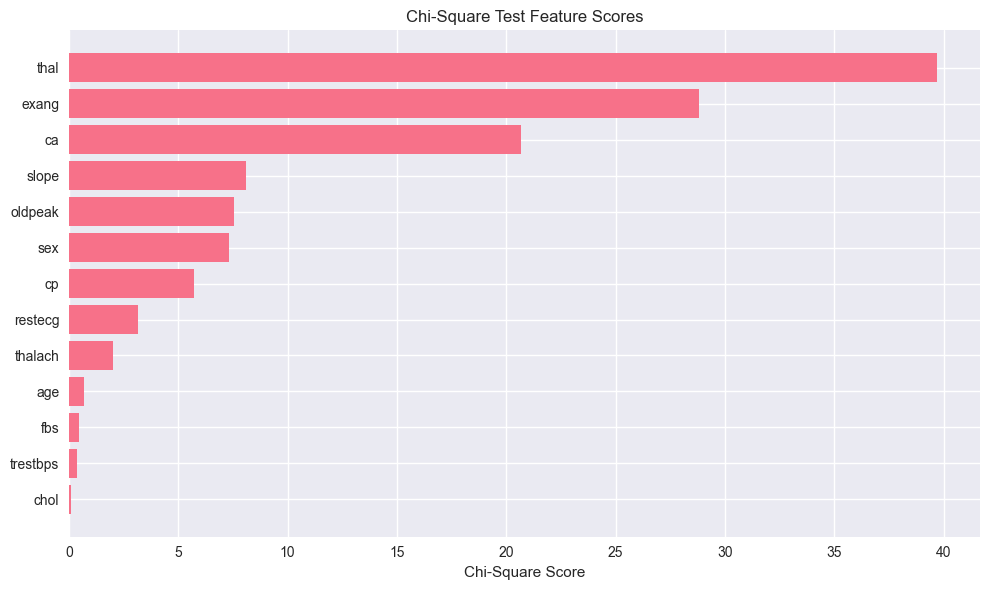


F-Score Test Results:
     feature     f_score       p_value  selected
12      thal  101.032412  4.584116e-20      True
11        ca   60.252389  2.400118e-13      True
8      exang   51.486909  8.931125e-12      True
7    thalach   48.347133  3.358391e-11      True
2         cp   45.883288  9.603185e-11      True
9    oldpeak   43.615028  2.549157e-10      True
10     slope   28.023125  2.705058e-07      True
1        sex   25.215352  1.000435e-06      True
0        age   11.035221  1.033443e-03     False
6    restecg    6.334802  1.249207e-02     False
3   trestbps    4.528441  3.435545e-02     False
4       chol    1.438593  2.315500e-01     False
5        fbs    0.506449  4.773712e-01     False

Features selected by F-score test: 8
['sex', 'cp', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [6]:
# Visualize Chi-Square scores
plt.figure(figsize=(10, 6))
plt.barh(range(len(chi2_results)), chi2_results['chi2_score'])
plt.yticks(range(len(chi2_results)), chi2_results['feature'])
plt.xlabel('Chi-Square Score')
plt.title('Chi-Square Test Feature Scores')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Also try F-score for comparison
f_selector = SelectKBest(f_classif, k=8)
X_train_f = f_selector.fit_transform(X_train_scaled, y_train)

f_scores = f_selector.scores_
f_pvalues = f_selector.pvalues_

f_results = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'f_score': f_scores,
    'p_value': f_pvalues,
    'selected': f_selector.get_support()
}).sort_values('f_score', ascending=False)

print("\nF-Score Test Results:")
print(f_results)

f_selected_features = X_train_scaled.columns[f_selector.get_support()].tolist()
print(f"\nFeatures selected by F-score test: {len(f_selected_features)}")
print(f_selected_features)


## 4. Combine Results and Select Final Features


In [7]:
# Combine all feature selection results
print("Feature Selection Summary:")
print("="*50)
print(f"Random Forest selected: {rf_selected_features}")
print(f"RFE selected: {rfe_selected_features}")
print(f"Chi-Square selected: {chi2_selected_features}")
print(f"F-score selected: {f_selected_features}")

# Find features that appear in multiple methods
all_features = set(X_train_scaled.columns)
feature_votes = {}

for feature in all_features:
    votes = 0
    if feature in rf_selected_features:
        votes += 1
    if feature in rfe_selected_features:
        votes += 1
    if feature in chi2_selected_features:
        votes += 1
    if feature in f_selected_features:
        votes += 1
    feature_votes[feature] = votes

# Sort by votes
feature_votes_df = pd.DataFrame.from_dict(feature_votes, orient='index', columns=['votes'])
feature_votes_df = feature_votes_df.sort_values('votes', ascending=False)
print(f"\nFeature Voting Results:")
print(feature_votes_df)

# Select features with at least 2 votes
final_selected_features = feature_votes_df[feature_votes_df['votes'] >= 2].index.tolist()
print(f"\nFinal Selected Features (≥2 votes): {len(final_selected_features)}")
print(final_selected_features)

# If too few features, add top-voted single features
if len(final_selected_features) < 6:
    additional_features = feature_votes_df[feature_votes_df['votes'] == 1].head(6-len(final_selected_features)).index.tolist()
    final_selected_features.extend(additional_features)
    print(f"\nAdded additional features to reach minimum 6: {additional_features}")
    print(f"Updated final selection: {final_selected_features}")


Feature Selection Summary:
Random Forest selected: ['thalach', 'cp', 'thal', 'ca', 'age', 'oldpeak', 'chol', 'trestbps', 'exang']
RFE selected: ['sex', 'cp', 'thalach', 'exang', 'slope', 'ca', 'thal']
Chi-Square selected: ['sex', 'cp', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
F-score selected: ['sex', 'cp', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Feature Voting Results:
          votes
thal          4
exang         4
ca            4
cp            4
thalach       3
slope         3
sex           3
oldpeak       3
age           1
trestbps      1
restecg       1
chol          1
fbs           0

Final Selected Features (≥2 votes): 8
['thal', 'exang', 'ca', 'cp', 'thalach', 'slope', 'sex', 'oldpeak']


Final dataset shape: (242, 8)
Selected features: ['thal', 'exang', 'ca', 'cp', 'thalach', 'slope', 'sex', 'oldpeak']


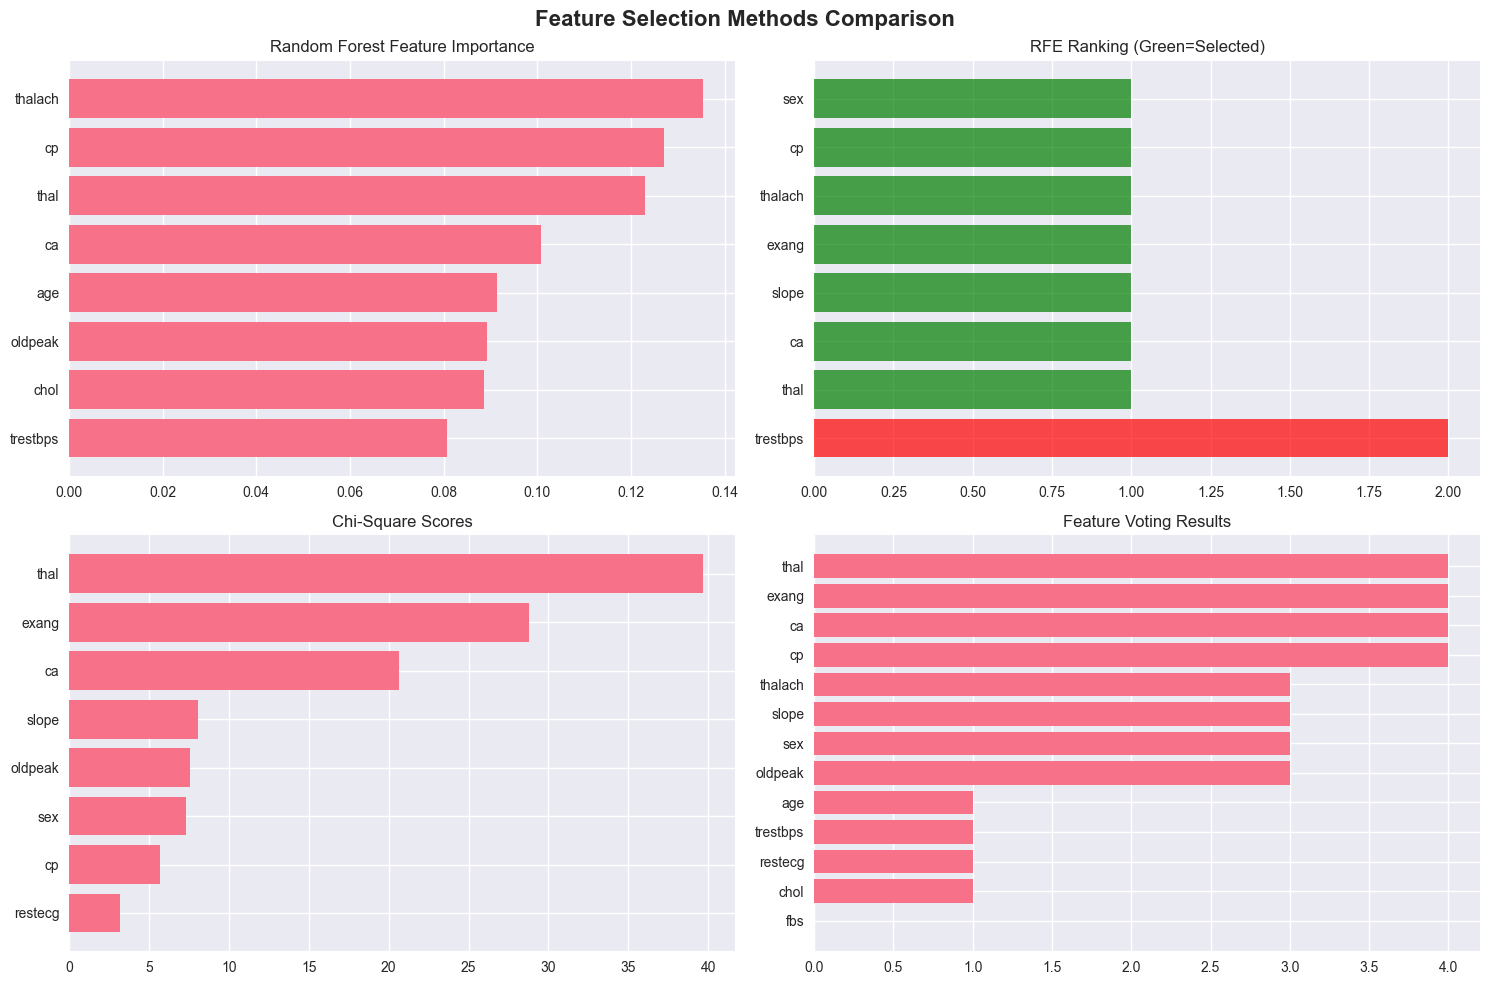

In [8]:
# Create final datasets with selected features
X_train_selected = X_train_scaled[final_selected_features]
X_test_selected = X_test_scaled[final_selected_features]

print(f"Final dataset shape: {X_train_selected.shape}")
print(f"Selected features: {list(X_train_selected.columns)}")

# Visualize feature selection comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Feature Selection Methods Comparison', fontsize=16, fontweight='bold')

# Random Forest importance
axes[0, 0].barh(range(len(feature_importance.head(8))), feature_importance.head(8)['importance'])
axes[0, 0].set_yticks(range(len(feature_importance.head(8))))
axes[0, 0].set_yticklabels(feature_importance.head(8)['feature'])
axes[0, 0].set_title('Random Forest Feature Importance')
axes[0, 0].invert_yaxis()

# RFE ranking
top_rfe = rfe_ranking_df.head(8)
colors = ['green' if selected else 'red' for selected in top_rfe['selected']]
axes[0, 1].barh(range(len(top_rfe)), top_rfe['ranking'], color=colors, alpha=0.7)
axes[0, 1].set_yticks(range(len(top_rfe)))
axes[0, 1].set_yticklabels(top_rfe['feature'])
axes[0, 1].set_title('RFE Ranking (Green=Selected)')
axes[0, 1].invert_yaxis()

# Chi-Square scores
axes[1, 0].barh(range(len(chi2_results.head(8))), chi2_results.head(8)['chi2_score'])
axes[1, 0].set_yticks(range(len(chi2_results.head(8))))
axes[1, 0].set_yticklabels(chi2_results.head(8)['feature'])
axes[1, 0].set_title('Chi-Square Scores')
axes[1, 0].invert_yaxis()

# Final voting results
axes[1, 1].barh(range(len(feature_votes_df)), feature_votes_df['votes'])
axes[1, 1].set_yticks(range(len(feature_votes_df)))
axes[1, 1].set_yticklabels(feature_votes_df.index)
axes[1, 1].set_title('Feature Voting Results')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()


In [9]:
# Save feature selection results
import joblib

# Save the feature selection models
joblib.dump(rfe_optimal, '../models/rfe_selector.pkl')
joblib.dump(chi2_selector, '../models/chi2_selector.pkl')
joblib.dump(f_selector, '../models/f_selector.pkl')

# Save selected features datasets
X_train_selected.to_csv('../data/X_train_selected.csv', index=False)
X_test_selected.to_csv('../data/X_test_selected.csv', index=False)

# Save feature selection summary
feature_selection_summary = {
    'final_selected_features': final_selected_features,
    'rf_selected': rf_selected_features,
    'rfe_selected': rfe_selected_features,
    'chi2_selected': chi2_selected_features,
    'f_selected': f_selected_features,
    'feature_votes': feature_votes
}

joblib.dump(feature_selection_summary, '../models/feature_selection_summary.pkl')

print("✅ Feature selection completed!")
print("✅ Selected feature datasets saved!")
print("✅ Feature selection models and summary saved!")
print(f"\nFeature Selection Summary:")
print(f"- Original features: {X_train_scaled.shape[1]}")
print(f"- Selected features: {len(final_selected_features)}")
print(f"- Feature reduction: {((X_train_scaled.shape[1] - len(final_selected_features)) / X_train_scaled.shape[1] * 100):.1f}%")
print(f"- Final selected features: {final_selected_features}")
print("\nFiles saved:")
print("- ../data/X_train_selected.csv, X_test_selected.csv")
print("- ../models/rfe_selector.pkl, chi2_selector.pkl, f_selector.pkl")
print("- ../models/feature_selection_summary.pkl")


✅ Feature selection completed!
✅ Selected feature datasets saved!
✅ Feature selection models and summary saved!

Feature Selection Summary:
- Original features: 13
- Selected features: 8
- Feature reduction: 38.5%
- Final selected features: ['thal', 'exang', 'ca', 'cp', 'thalach', 'slope', 'sex', 'oldpeak']

Files saved:
- ../data/X_train_selected.csv, X_test_selected.csv
- ../models/rfe_selector.pkl, chi2_selector.pkl, f_selector.pkl
- ../models/feature_selection_summary.pkl
